In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')

from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation, OneFormerConfig
from transformers.models.oneformer.image_processing_oneformer import load_metadata, prepare_metadata
from safetensors.torch import load_model, save_model
from config import DATASET_DIR, CLASS_INFO_PATH, MAIN_PROJECT_DIR, GALAXY_MEAN, GALAXY_STD
from visual import *
from dataset import *
from utils import *

In [ ]:
tr_loss = []
val_loss = []
with open("../out/tr_loss.txt", "r") as f:
    tr_loss = [float(val.split()[0]) for val in f.readlines()]

with open("../out/val_loss.txt", "r") as f:
    val_loss = [float(val.split()[0]) for val in f.readlines()]

In [2]:
model_card = "shi-labs/oneformer_ade20k_swin_tiny"

id2label, label2id = get_id2label_mappings()
config = OneFormerConfig.from_pretrained(model_card, 
                                        num_classes = len(id2label),
                                        id2label = id2label,
                                        label2id = label2id,
                                        is_training=False)

model = OneFormerForUniversalSegmentation.from_pretrained(model_card, config=config, ignore_mismatched_sizes=True)
processor = OneFormerProcessor.from_pretrained(model_card)

# Metadata must be set according to the dataset through the class_info.json file. Background class must be specified as well. 
processor.image_processor.repo_path = MAIN_PROJECT_DIR
processor.image_processor.class_info_file = os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)
processor.image_processor.metadata = prepare_metadata(load_metadata(MAIN_PROJECT_DIR, os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)))
processor.image_processor.num_text = model.config.num_queries - model.config.text_encoder_n_ctx
processor.image_processor.do_resize = False
processor.image_processor.do_rescale = False

# strict = False because we don't need the text mapper at inference time
unmatched = load_model(model, "../safetensors/galaxy.safetensors", strict=False)

/home/panzaresce/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized because the shapes did not match:
- model.transformer_module.decoder.class_embed.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.transformer_module.decoder.class_embed.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([7]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use i

In [3]:
# Only the text_mapper should be unmatched with the pretrained model
for el in unmatched[1]:
    if el.split(".")[1] != "text_mapper":
        print(f"BAD: {el}")

In [4]:
# dataset_train = GalaxyDataset(DATASET_DIR, "train", processor, CLASS_INFO_PATH, None, GALAXY_MEAN, GALAXY_STD, load_on_demand=True, subset_idx=20)
dataset_test = GalaxyDataset(DATASET_DIR, "test", processor, CLASS_INFO_PATH, None, GALAXY_MEAN, GALAXY_STD, load_on_demand=True, subset_idx=20)

In [5]:
len(dataset_test)

20

In [6]:
run_iou, run_dice = compute_metrics(dataset_test, model, processor)
print(f"mIoU: {run_iou / len(dataset_test):.4f}")
print(f"Dice: {run_dice / len(dataset_test):.4f}")

/home/panzaresce/anaconda3/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


mIoU: 0.2345
Dice: 0.2723


In [9]:
bs=2
test_dataloader = DataLoader(dataset_test, batch_size=bs, shuffle=True)

model.to("cuda")
model.eval()
model.model.is_training = False

running_iou = 0.0
running_dice = 0.0

for batch_idx, batch in enumerate(test_dataloader):
    # print(f"Iteration n. {batch_idx+1} / {len(test_dataloader)}", end="\r")
    gt_mask = dataset_test.get_gt_mask(batch)

    batch.pop("mask_labels", None)
    batch.pop("text_inputs", None)
    batch = {k:v.to("cuda") for k,v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    pred_mask = torch.stack(processor.post_process_semantic_segmentation(outputs, target_sizes=[(256,256) for _  in range(outputs.masks_queries_logits.shape[0])]))
    running_iou += compute_iou(gt_mask, pred_mask.cpu(), batch["class_labels"][:, 1].cpu()).sum()
    running_dice += compute_dice(gt_mask, pred_mask.cpu(), batch["class_labels"][:, 1].cpu()).sum()
    
    break

In [10]:
outputs.class_queries_logits.softmax(dim=-1)[..., :-1].shape

torch.Size([2, 150, 6])

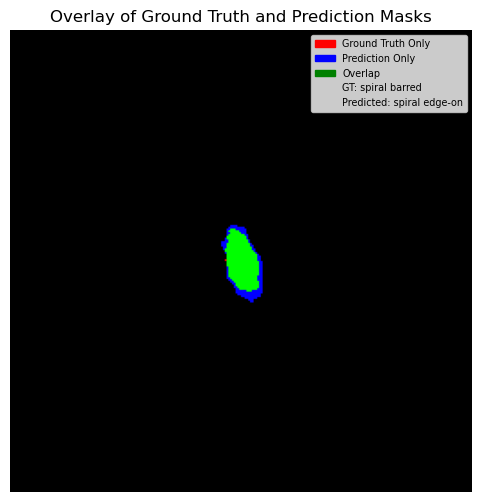

In [29]:
mask_gt_overlap(gt_mask[0], pred_mask[0], id2label)

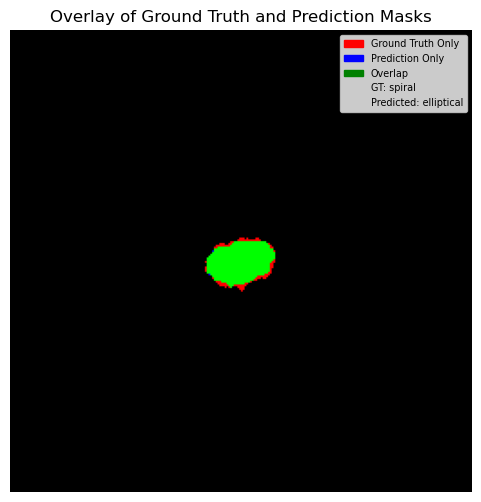

In [11]:
mask_gt_overlap(gt_mask[1], pred_mask[1], id2label)